Nama  : Steven Christ Pinantyo Arwidarasto

Kelas : Alfatih

Group : V

# Student Activity
Lakukan proses di atas menggunakan dataset review product https://drive.google.com/file/d/1qn5WXp-H95_FL_Rx5oqvfZaflYdHsnrF/view?usp=sharing

Tugas Anda:
- Tentukan langkah pre-processing yang tepat untuk dataset di atas.
- Gunakan range `n_gram` yang berbeda. Amati apa perbedaannya.
- Menurut Anda, apakah `term` yang dihasilkan (`X_kbest_features`) pada feature selection sudah memiliki informasi yang relevan?

Setelah dikerjakan, buatlah resume berdasarkan pengalaman Anda dalam melakukan pre-processing dan feature engineering.

Kumpulkan tugas Anda pada: https://s.id/tugas-nlp-ofa



In [1]:
import pandas as pd
import numpy as np

In [2]:
# Membaca data
df = pd.read_csv("/content/20191002-reviews.csv", encoding='utf-8')
df.head()

,itemId,category,name,rating,originalRating,reviewTitle,reviewContent,likeCount,upVotes,downVotes,helpful,relevanceScore,boughtDate,clientType,retrievedDate
0,100002528,beli-harddisk-eksternal,Kamal U.,5,NaN,NaN,bagus mantap dah sesui pesanan,0,0,0,True,26.51,09 Apr 2019,androidApp,2019-10-02
1,100002528,beli-harddisk-eksternal,yofanca m.,4,NaN,NaN,"Bagus, sesuai foto",0,0,0,True,22.49,24 Sep 2017,androidApp,2019-10-02
2,100002528,beli-harddisk-eksternal,Lazada Customer,5,NaN,ok mantaaapppp barang sesuai pesanan.. good,okkkkk mantaaaaaaapppp ... goood,0,0,0,True,21.50,04 Apr 2018,androidApp,2019-10-02
3,100002528,beli-harddisk-eksternal,Lazada Customer,4,NaN,NaN,bagus sesuai,0,0,0,True,20.51,22 Sep 2017,androidApp,2019-10-02
4,100002528,beli-harddisk-eksternal,Yosep M.,5,NaN,NaN,NaN,0,0,0,True,16.01,17 Agu 2018,androidApp,2019-10-02


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203787 entries, 0 to 203786
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   itemId          203787 non-null  int64  
 1   category        203787 non-null  object 
 2   name            203787 non-null  object 
 3   rating          203787 non-null  int64  
 4   originalRating  8 non-null       float64
 5   reviewTitle     23404 non-null   object 
 6   reviewContent   107029 non-null  object 
 7   likeCount       203787 non-null  int64  
 8   upVotes         203787 non-null  int64  
 9   downVotes       203787 non-null  int64  
 10  helpful         203787 non-null  bool   
 11  relevanceScore  203787 non-null  float64
 12  boughtDate      196680 non-null  object 
 13  clientType      203787 non-null  object 
 14  retrievedDate   203787 non-null  object 
dtypes: bool(1), float64(2), int64(5), object(7)
memory usage: 22.0+ MB


In [4]:
df.isnull().sum()

itemId                 0
category               0
name                   0
rating                 0
originalRating    203779
reviewTitle       180383
reviewContent      96758
likeCount              0
upVotes                0
downVotes              0
helpful                0
relevanceScore         0
boughtDate          7107
clientType             0
retrievedDate          0
dtype: int64

> Berdasarkan deskripsi jumlah nilai null diatas, didapatkan ada banyak sekali data dengan nilai NaN. Dalam kasus ini, saya memilih untuk menghapus daa NaN dengan axis row pada kolom reviewContent, dan boughtDate dikarenakan review yang tidak memiliki boughtDate (tgl pembelian produk) memiliki potensi besar sebagai review yang tidak valid

In [5]:
""" 
  Melakukan drop baris untuk nilai null pada kolom
  boughtDate
"""
df.dropna(subset=['boughtDate','reviewContent'], axis=0, inplace=True)

> Maka saya akan menggunakan category, reviewcontent dan rating sebagai target label dari review yang diberikan.

In [6]:
# Pemilihan kolom dan mengambil 5000 data
data = df[["category","reviewContent","rating"]]
data.head()

,category,reviewContent,rating
0,beli-harddisk-eksternal,bagus mantap dah sesui pesanan,5
1,beli-harddisk-eksternal,"Bagus, sesuai foto",4
2,beli-harddisk-eksternal,okkkkk mantaaaaaaapppp ... goood,5
3,beli-harddisk-eksternal,bagus sesuai,4
8,beli-harddisk-eksternal,baru 10 bulan layarnya dah bergaris,1


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

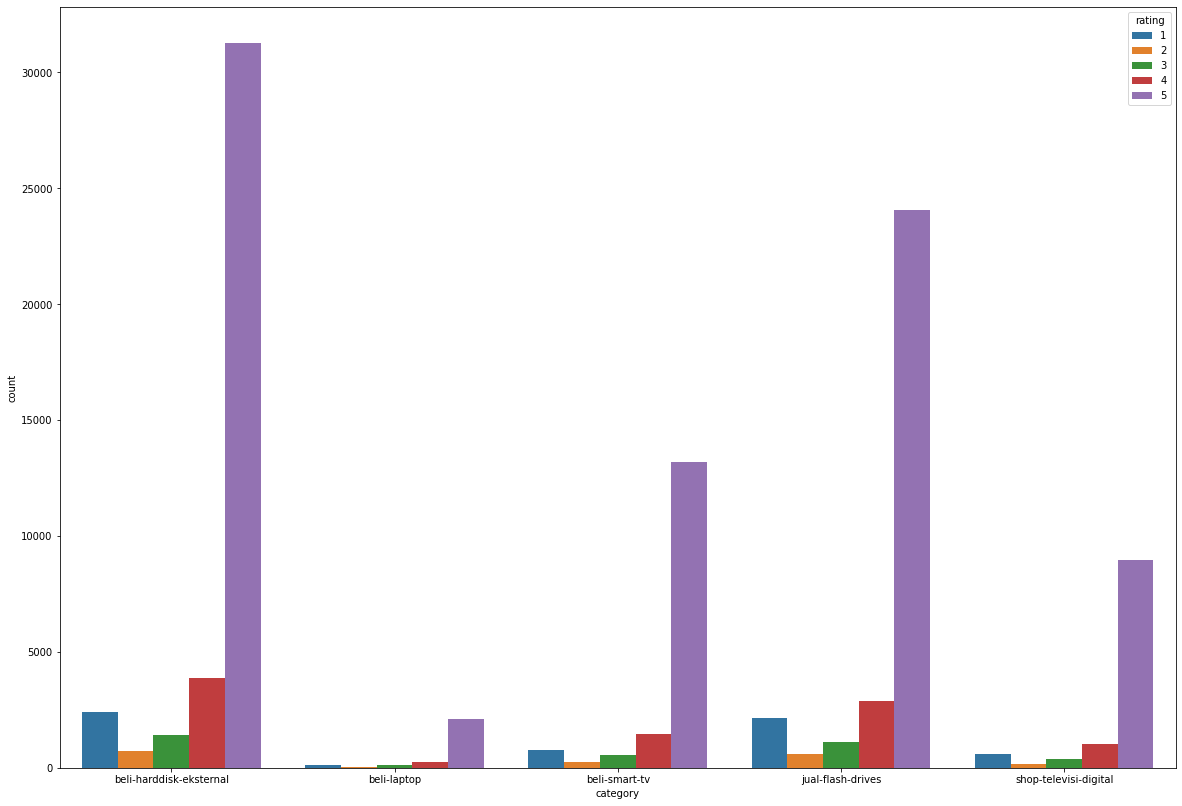

In [8]:
plt.figure(figsize=[20,14])
sns.countplot(x="category",hue="rating", data=data)
plt.show()

> Adapun distribusi jumlah transaksi yang didominasi oleh pembelian harddisk eksternal, dan penjualan flashdrive.

# Text Pre-processing

> Saya memilih jumlah baris data sebanyak 5000 untuk diproses dengan kategori yang sama yaitu pembelian harddisk eksternal.

In [9]:
data = data.iloc[:5000,:]

In [10]:
import sys
import re
import nltk
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
!{sys.executable} -m pip -q install sastrawi

In [12]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

> Akan digunakan normalisasi untuk menghilangkan bahasa gaul, singkatan menjadi kata baku

In [13]:
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2022-03-31 00:40:12--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv.2’

key_norm.csv.2      100%[===================>]  79.07K  --.-KB/s    in 0.001s  

2022-03-31 00:40:12 (56.3 MB/s) - ‘key_norm.csv.2’ saved [80969/80969]



> Adapun penambahan kata Lazada, dikarenakan brand aplikasi tidak akan dimasukan kedalam review sentimen analisis produk

In [14]:
# Konfigurasi Text Processing
stopwords_ind = stopwords.words('indonesian')
stopwords_ind += ["lazada"]
key_norm = pd.read_csv('key_norm.csv')
stemmer = StemmerFactory().create_stemmer()

> Dalam casefoldingnya, akan dilakukan filter regex yang hanya menerima huruf A-Z lowercase dan uppercase saja. Hal ini dikarenakan dataset memiliki unsur review content berupa emoji serta simbol-simbol

In [15]:
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[^\sA-Za-z]','', text)            # Menghapus karakter tanda baca dan simbol
  text = text.strip()
  return text

def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

def stemming(text):
  text = stemmer.stem(text)
  return text

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

def text_preprocessing_process(text, stemming=0):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  return text

def text_preprocessing_process_stemming(text):
  text = stemming(text)
  return text

> Adapun kolom yang ada pada dataframe, yaitu kategori, review konten, dan rating

In [16]:
data.columns

Index(['category', 'reviewContent', 'rating'], dtype='object')

> Dikarenakan kolom review konten digunakan untuk sentimen analisis, maka akan dilakukan teks prosesing pada kolom review konten

In [17]:
data["clean_reviewContent"] = data["reviewContent"].apply(text_preprocessing_process)
data["clean_reviewContent_stemming"] = data["clean_reviewContent"].apply(text_preprocessing_process_stemming)
data.head()

,category,reviewContent,rating,clean_reviewContent,clean_reviewContent_stemming
0,beli-harddisk-eksternal,bagus mantap dah sesui pesanan,5,bagus mantap sesui pesanan,bagus mantap sesui pesan
1,beli-harddisk-eksternal,"Bagus, sesuai foto",4,bagus sesuai foto,bagus sesuai foto
2,beli-harddisk-eksternal,okkkkk mantaaaaaaapppp ... goood,5,okkkkk mantaaaaaaapppp goood,okkkkk mantaaaaaaapppp goood
3,beli-harddisk-eksternal,bagus sesuai,4,bagus sesuai,bagus sesuai
8,beli-harddisk-eksternal,baru 10 bulan layarnya dah bergaris,1,layarnya bergaris,layar gar


In [18]:
data.drop(['category','reviewContent'],axis=1,inplace=True)

> Setelah itu akan dipisahkan fitur dan target

In [19]:
X = data['clean_reviewContent_stemming']
y = data["rating"]

# Ekstraksi Fitur

> Adapun metode yang digunakan untuk ekstraksi fitur untuk mengambil fitur teroptimal yaitu dengan menggunakan TF-IDF. Adapun ngram yang digunakan berbeda, dalam kasus ini akan digunakan ngram dengan kombinasi unigram, bigram, dan trigram

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,3))
tf_idf.fit(X)

X_tf_idf = tf_idf.transform(X)

In [21]:
data_tf_idf = pd.DataFrame(tf_idf.transform(X).toarray(), columns=tf_idf.get_feature_names_out())
data_tf_idf

,ababila,ababila hanphone,ababila hanphone dlamnga,abai,abai rating,abai rating cacat,abal,abal abal,abal abal lagibaguslahmksh,abal file,...,zipper nya rapih,zippernya,zippernya kecewa,zippernya kecewa susah,zone,zonk,zonk deeh,zs,zs samsung,zs samsung hs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Seleksi Fitur

> Setelah dilakukan ekstraksi fitur, maka akan digunakan seleksi 3000 fitur terbaik dengan menggunakan metode filter chi-square yang mengubah jumlah fitur awal sebesar 40885 menjadi 3000

> Nilai X akan diambil dari nilai hasil fitur ekstraksi dengan metode TF-IDF

In [22]:
X_seleksi = np.array(data_tf_idf)
y_seleksi = np.array(y)

In [23]:
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

chi2_features = SelectKBest(chi2, k=3000) 
X_kbest_features = chi2_features.fit_transform(X_seleksi, y_seleksi) 
  
print('Jumlah fitur awal:', X_seleksi.shape[1]) 
print('Jumlah fitur setelah pemilihan:', X_kbest_features.shape[1]) 

Jumlah fitur awal: 40885
Jumlah fitur setelah pemilihan: 3000


In [24]:
# Pengubahan data hasil skor chi-square menjadi dataframe dengan kolom nilai
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])

In [25]:
# Penambahan fitur yang diambil dari metode TF-IDF dan disortir dari yang tertinggi nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
17947,48.814944,kecewa
32463,47.744904,rusak
21734,44.619527,lumayan
17202,44.248134,kadang
21873,42.991987,lumyan
...,...,...
3379,0.022657,barang aman size
24865,0.022657,normal ngomong
24866,0.022657,normal ngomong ngomong
24886,0.022657,normal unuk


In [26]:
# Menampilkan mask pada fitur yang diseleksi
mask = chi2_features.get_support()
mask

array([False, False, False, ..., False, False, False])

In [27]:
# Membuat list baru untuk fitur optimal yang telah diseleksi dengan metode chi-square
new_feature = []
for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature
len(selected_feature)

3000

In [28]:
# pengubahan list fitur optimal menjadi dataframe
data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,abal file,abal file simpan,abal nih,abal nih fd,activationnyacode,activationnyacode nyaa,activationnyacode nyaa invalid,aju,aju kembali,aju kembali dana,...,yak terimakasih,yak terimakasih barang,yasy,yasy nrima,ygcabang,ygcabang beli,ygcabang beli program,zippernya,zippernya kecewa,zippernya kecewa susah
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Wordcloud

> Untuk visualisasi kata penting yang telah dihitung melalui chi

In [29]:
import cv2
from wordcloud import WordCloud

In [30]:
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg

--2022-03-31 00:49:20--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34396 (34K) [image/jpeg]
Saving to: ‘cloud.jpg.3’

cloud.jpg.3         100%[===================>]  33.59K  --.-KB/s    in 0s      

2022-03-31 00:49:20 (105 MB/s) - ‘cloud.jpg.3’ saved [34396/34396]



In [31]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

In [32]:
def wordcloud(title, data, kolom):
  # WordCloud Label Positive Sentiment
  data_wordcloud = data
  list_data = []

  for t in data_wordcloud[kolom]:
    list_data.append(t)

  list_data = pd.Series(list_data).str.cat(sep=' ')
  from wordcloud import WordCloud
  wordcloud = WordCloud(width=1000, height=200, margin=10,
                        background_color='white', colormap='Dark2',
                        max_font_size=200, min_font_size=25,
                        mask=cloud_mask, contour_width=10, contour_color='firebrick',
                        max_words=100).generate(list_data)
  plt.figure(figsize=(5,3))
  plt.imshow(wordcloud)
  plt.title(title)
  plt.axis("off")
  plt.show()

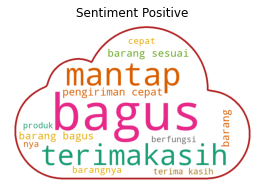

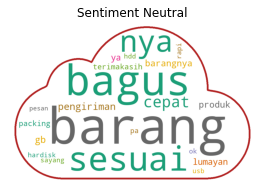

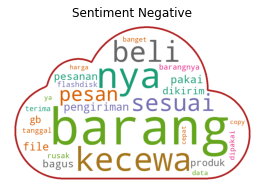

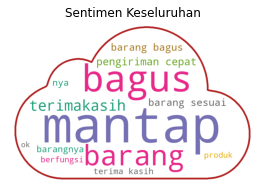

In [33]:
list_data = [data[data.rating > 3], data[data.rating == 3], data[data.rating < 3]]
list_label = ["Sentiment Positive","Sentiment Neutral","Sentiment Negative"]
for datas in range(len(list_data)) :
  wordcloud(list_label[datas], list_data[datas],"clean_reviewContent")

wordcloud("Sentimen Keseluruhan", data, "clean_reviewContent")

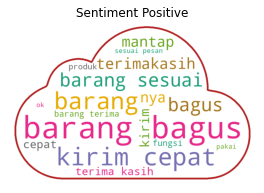

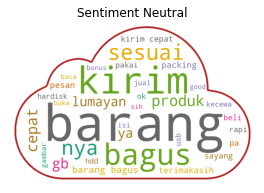

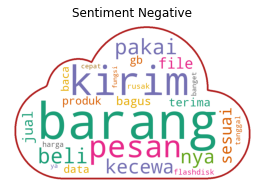

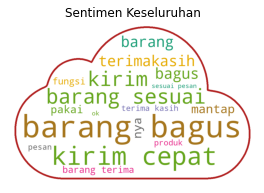

In [34]:
# Dengan stemming
list_data = [data[data.rating > 3], data[data.rating == 3], data[data.rating < 3]]
list_label = ["Sentiment Positive","Sentiment Neutral","Sentiment Negative"]
for datas in range(len(list_data)) :
  wordcloud(list_label[datas], list_data[datas],'clean_reviewContent_stemming')

wordcloud("Sentimen Keseluruhan", data, 'clean_reviewContent_stemming')

> Berdasarkan cloudword, didapatkan beberapa kata pada tiap sentimen yang sangat domain, antara lain: 

* Sentimen positif (lebih dari rating 3) di dominasi dengan kata bagus, kirim, cepat, terima kasih

* Sentimen netral (sama dengan 3) terdapat kata bagus, sesuai, lumayan, dan cepat

* Sentimen negatif (kurang dari 3) terdapat kata kecewa, rusak

> Adapun sentimen umum yang dikhususkan pada kategori pembelian harddisk menghasilkan review yang positif.




- Tentukan langkah pre-processing yang tepat untuk dataset di atas.

> data teks yang berada pada kolom reviewContent memerlukan pembersihan dari simbol / emoji, angka, atau url, maka hanya akan diterima teks yang memiliki huruf A-Z dan a-z saja. Adapun percobaan stemming dan preprocessing non-stemming yang menghasilkan kata yang lebih sederhana bila menggunakan stemming, akan tetapi hasil kata dari preprocessing non-stemming mendapatkan penggunaan konteks kata yang lebih jelas. Adapun penghapusan stopword seperti kata hubung, kata Lazada sebagai brand aplikasi dikarenakan kasus sentimen ini merupakan sentimen terhadap pembelian/penjualan suatu produk. Lalu dibutuhkannya standarisasi bagi kata singkatan atau kata slang menjadi kata bakunya.

- Gunakan range `n_gram` yang berbeda. Amati apa perbedaannya.
> Penggunaan 1,1 hanya akan memberikan data unigram, sedangkan 1,3 yang digunakan pada kasus ini menghasilkan bentuk kata unigram, bigram, dan trigram.

- Menurut Anda, apakah `term` yang dihasilkan (`X_kbest_features`) pada feature > selection sudah memiliki informasi yang relevan?
Ya, berdasarkan kata-kata yang telah di seleksi, telah menghasilkan kata yang relevan

- Setelah dikerjakan, buatlah resume berdasarkan pengalaman Anda dalam melakukan pre-processing dan feature engineering.

> Mula-mula suatu teks akan diimport dari suatu dataset kedalam variable dataframe, dan akan dilakukan pengecekan nilai null. Bila jumlah data besar, maka dapat dihapus bagian-bagian yang null, sedangkan bila tidak, maka dapat dikonversikan ke kata berdasarkan rating sentimennya.

> Lalu akan dilakukan preprocessing berupa penghapusan kata dengan pola url, angka, simbol, emoji, dan tanda baca. Adapun penggunaan standarisasi untuk mengkonversi kata slang atau singkatan menjadi kata bakunya dan dijadikan kata dasar. Selanjutnya adalah penghapusan kata hubung atau kata-kata yang sering muncul dan tidak memiliki makna berarti (stopword removal)

> Selanjutnya akan dilakukan fitur ekstraksi menggunakan TF-IDF dengan melakukan perhitungan frekuensi untuk mengetahui relevansi kata terhadap dokumen.

> Lalu akan digunakan chi-square test untuk menyeleksi fitur terbaik sebanyak K

> Adapun kesulitan dalam pengolahan teks yaitu data review yang diberikan terkadang memiliki review yang positif pada rating rendah atau penggunaan kata positif dalam konteks sarkasme.